In [2]:
import torch
import copy
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim
from torch import nn
from torch.nn import functional as F

from collections import OrderedDict

import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
train_dataset = datasets.MNIST(root='C:/Users/WorkStation/Desktop/Git_Repositories/Dataset', train = True, transform = transforms.ToTensor(), download = True)
test_dataset = datasets.MNIST(root='C:/Users/WorkStation/Desktop/Git_Repositories/Dataset', train = False, transform = transforms.ToTensor(), download = True)

C:\Users\WorkStation\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
def data_split(train_dataset, args):
    dataset_list=[]

    num_data_arr = np.ones((args.num_clients,), dtype=int) * int(len(train_dataset)/args.num_clients)
    dataset_list = torch.utils.data.random_split(train_dataset, num_data_arr)
    return dataset_list

def list_np_tensor(param_data):
    data = np.concatenate((param_data['net.0.weight'].cpu().numpy(),np.expand_dims(param_data['net.0.bias'].cpu().numpy(), axis=1)),axis=1)
    data = torch.Tensor(data)
    return data

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential(nn.Linear(28*28, 10)
                                )

    def forward(self, x):
        x = x.view(-1,28*28)
        out = self.net(x)
        return out

In [6]:
class Encoder(nn.Module):
    def __init__(self, hidden_dim):
        super(Encoder, self).__init__()

        self.hidden_dim = hidden_dim
        self.encoder = nn.Sequential(nn.Linear(7851, 785),
                                    nn.ReLU(),
                                    nn.Linear(785, 50),
                                    nn.ReLU(),
                                    nn.Linear(50, self.hidden_dim)
                                    )
            
    def forward(self, x):
        output = self.encoder(x)
        return output


class Decoder(nn.Module):
    def __init__(self, hidden_dim):
        super(Decoder, self).__init__()

        self.hidden_dim = hidden_dim
        self.decoder = nn.Sequential(nn.Linear(self.hidden_dim, 50),
                                    nn.ReLU(),
                                    nn.Linear(50, 785),
                                    nn.ReLU(),
                                    nn.Linear(785, 7851)
                                    )
            
    def forward(self, x):
        output = self.decoder(x)
        return output

In [7]:
def define_client(partition, global_weights, r, num, args):
    train_loader = DataLoader(partition['train'][num], batch_size=args.batch_size, shuffle=True)
    
    if r == 0:
        net = Net().to(device)

    else:
        net = Net().to(device)        
        net.load_state_dict(global_weights)
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=args.lr)

    return net, train_loader, criterion, optimizer

In [8]:
def train(net, train_loader, criterion, optimizer, args):
    net.train()

    for epoch in range(args.num_epochs):        
        for images, labels in iter(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad() 
            
            outputs = net(images)  
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
    return net

In [9]:
def client_encode(net, r, encoder):
    round_tensor = torch.tensor(r).view(-1, 1).to(device)

    param_data = copy.deepcopy(net.state_dict())
    tensor_data = list_np_tensor(param_data).view(-1,7850).to(device)
    dt_r = torch.cat((tensor_data, round_tensor), dim=1)
    encoded_data = encoder(dt_r)
    return encoded_data

In [10]:
def Dec_Fed_AVG(model, decoder, client_enc_data_list, args):
    model.train()
    decoded_data_list = []
    global_weights = OrderedDict()

    for i in range(args.num_clients):
        client_enc_data_list[i] = client_enc_data_list[i].to(device)
        out = decoder(client_enc_data_list[i])[:,:-1].view((-1, 785)).cpu().detach().numpy()    
        decoded_data_list.append(out)

    w_avg = np.mean(decoded_data_list, axis=0)
    global_weights['net.0.weight'] = torch.tensor(w_avg[:,:784]).clone().detach()
    global_weights['net.0.bias'] = torch.tensor(w_avg[:,784:].squeeze()).clone().detach()

    model.load_state_dict(global_weights)

    return model, global_weights

In [11]:
def test(model, partition, criterion, args):
    test_loader = DataLoader(partition['test'], batch_size=args.batch_size, shuffle=True)
    model.eval()
        
    correct = 0 
    total = 0 
    loss = 0
    round_accuracy = 0
    round_loss = 0

    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)
    
    round_loss = loss / len(test_loader)
    round_accuracy = (correct / total) * 100.0
    
    return round_loss, round_accuracy

In [12]:
def experiment(partition, args):
    encoder = Encoder(args.hidden_dim)
    decoder = Decoder(args.hidden_dim)
    model = Net()
    encoder.load_state_dict(torch.load(args.enc_path))
    decoder.load_state_dict(torch.load(args.dec_path))

    encoder, decoder, model = encoder.to(device), decoder.to(device), model.to(device)
    
    global_weights = OrderedDict()
    round_losses = []
    round_acces = []


    for r in range(args.num_rounds):
        client_enc_data_list = []

        for num in range(args.num_clients):
            net, train_loader, criterion, optimizer = define_client(partition, global_weights, r, num, args)
            net = train(net, train_loader, criterion, optimizer, args)
            client_enc_data = client_encode(net, r, encoder)
            client_enc_data_list.append(client_enc_data)

        model, global_weights = Dec_Fed_AVG(model, decoder, client_enc_data_list, args)
        round_loss, round_acc = test(model, partition, criterion, args)

        if r%50 == 0 or r == (args.num_rounds-1):
            print(f'[Round: {r}]  Round Loss: {round_loss}  Round Acc: {round_acc:.2f}')

        round_losses.append(round_loss)
        round_acces.append(round_acc)
        
    return round_losses, round_acces

In [13]:
def plot_loss(round_loss, round_acc):
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1,2,1)
    plt.plot(round_loss, label = 'Loss')
    plt.xlabel('Rounds')
    plt.grid()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(round_acc, label = 'Accuracy')
    plt.xlabel('Rounds')
    plt.grid()
    plt.legend()

    plt.show()

##### **Normal AutoEncoder**

===== reverse: False =====
num_data: 100
[Round: 0]  Round Loss: 0.34895126059651377  Round Acc: 90.64
[Round: 50]  Round Loss: 0.3777275016158819  Round Acc: 91.45
[Round: 100]  Round Loss: 0.42001804664731024  Round Acc: 91.48
[Round: 150]  Round Loss: 0.44205000322312116  Round Acc: 91.38
[Round: 200]  Round Loss: 0.45595841243863106  Round Acc: 91.25
[Round: 250]  Round Loss: 0.4614613140374422  Round Acc: 91.07
[Round: 300]  Round Loss: 0.46062285497784616  Round Acc: 90.93
[Round: 350]  Round Loss: 0.45357570439577105  Round Acc: 90.51
[Round: 400]  Round Loss: 0.44775913015007973  Round Acc: 89.59
[Round: 450]  Round Loss: 0.49220624536275864  Round Acc: 86.80
[Round: 500]  Round Loss: 0.6767653781175613  Round Acc: 79.77
[Round: 550]  Round Loss: 0.9362163561582565  Round Acc: 71.53
[Round: 600]  Round Loss: 1.2155527275800706  Round Acc: 65.05
[Round: 650]  Round Loss: 1.57522709608078  Round Acc: 58.23
[Round: 700]  Round Loss: 1.9706418550014495  Round Acc: 52.54
[Round: 750

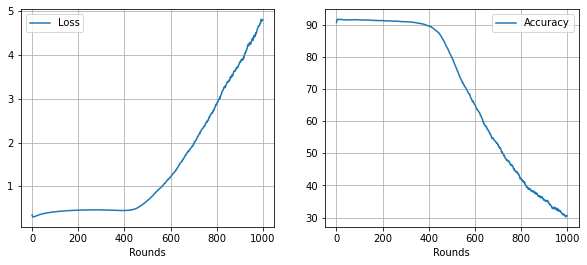

num_data: 500
[Round: 0]  Round Loss: 0.3084233649075031  Round Acc: 91.54
[Round: 50]  Round Loss: 0.30143890738487245  Round Acc: 91.95
[Round: 100]  Round Loss: 0.2939153215289116  Round Acc: 92.06
[Round: 150]  Round Loss: 0.28462851971387865  Round Acc: 92.12
[Round: 200]  Round Loss: 0.2772201009094715  Round Acc: 92.19
[Round: 250]  Round Loss: 0.27200178787112234  Round Acc: 92.33
[Round: 300]  Round Loss: 0.26908121787011624  Round Acc: 92.35
[Round: 350]  Round Loss: 0.26814126342535016  Round Acc: 92.39
[Round: 400]  Round Loss: 0.2692688736319542  Round Acc: 92.38
[Round: 450]  Round Loss: 0.2723508359491825  Round Acc: 92.47
[Round: 500]  Round Loss: 0.27778457462787626  Round Acc: 92.41
[Round: 550]  Round Loss: 0.2852914921194315  Round Acc: 92.32
[Round: 600]  Round Loss: 0.2959655371308327  Round Acc: 92.25
[Round: 650]  Round Loss: 0.3094781455397606  Round Acc: 91.94
[Round: 700]  Round Loss: 0.32752709209918973  Round Acc: 91.42
[Round: 750]  Round Loss: 0.348951672

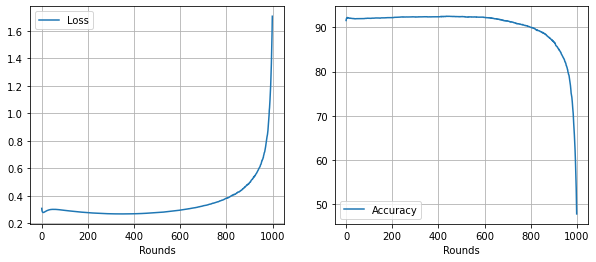

num_data: 1000
[Round: 0]  Round Loss: 0.3102110195159912  Round Acc: 91.65
[Round: 50]  Round Loss: 0.2906707830354571  Round Acc: 92.10
[Round: 100]  Round Loss: 0.2979190608114004  Round Acc: 91.96
[Round: 150]  Round Loss: 0.29708697367459536  Round Acc: 91.99
[Round: 200]  Round Loss: 0.29521158076822757  Round Acc: 92.00
[Round: 250]  Round Loss: 0.2933906465768814  Round Acc: 92.03
[Round: 300]  Round Loss: 0.2914000934362411  Round Acc: 92.00
[Round: 350]  Round Loss: 0.2897112063318491  Round Acc: 92.03
[Round: 400]  Round Loss: 0.2881041537225246  Round Acc: 92.11
[Round: 450]  Round Loss: 0.2863998655974865  Round Acc: 92.15
[Round: 500]  Round Loss: 0.2850170413404703  Round Acc: 92.17
[Round: 550]  Round Loss: 0.2835569652542472  Round Acc: 92.24
[Round: 600]  Round Loss: 0.2825626157224178  Round Acc: 92.23
[Round: 650]  Round Loss: 0.2813259872049093  Round Acc: 92.25
[Round: 700]  Round Loss: 0.28010982774198057  Round Acc: 92.24
[Round: 750]  Round Loss: 0.279314376264

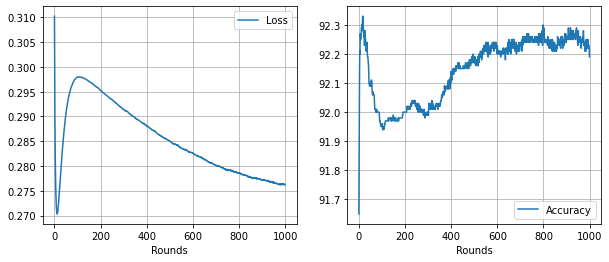

===== reverse: True =====
num_data: 100
[Round: 0]  Round Loss: 0.37776814460754393  Round Acc: 91.13
[Round: 50]  Round Loss: 0.27888577826321126  Round Acc: 92.16
[Round: 100]  Round Loss: 0.2755810553580523  Round Acc: 92.25
[Round: 150]  Round Loss: 0.27358836710453033  Round Acc: 92.23
[Round: 200]  Round Loss: 0.2728316727280617  Round Acc: 92.36
[Round: 250]  Round Loss: 0.2730166578292847  Round Acc: 92.32
[Round: 300]  Round Loss: 0.2742340735346079  Round Acc: 92.34
[Round: 350]  Round Loss: 0.2762261614203453  Round Acc: 92.44
[Round: 400]  Round Loss: 0.27888452924788  Round Acc: 92.31
[Round: 450]  Round Loss: 0.28216012138873336  Round Acc: 92.28
[Round: 500]  Round Loss: 0.28643914967775347  Round Acc: 92.25
[Round: 550]  Round Loss: 0.29071935027837753  Round Acc: 92.21
[Round: 600]  Round Loss: 0.2953693901747465  Round Acc: 92.03
[Round: 650]  Round Loss: 0.3014960443228483  Round Acc: 91.99
[Round: 700]  Round Loss: 0.3074099673330784  Round Acc: 91.90
[Round: 750]  

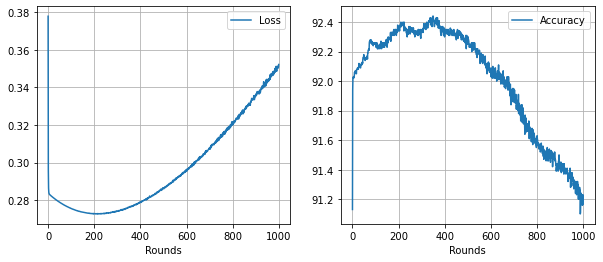

num_data: 500
[Round: 0]  Round Loss: 0.3217083005607128  Round Acc: 91.57
[Round: 50]  Round Loss: 0.27349782004952433  Round Acc: 92.28
[Round: 100]  Round Loss: 0.27284957610070704  Round Acc: 92.27
[Round: 150]  Round Loss: 0.27521244309842585  Round Acc: 92.32
[Round: 200]  Round Loss: 0.28026672288775445  Round Acc: 92.16
[Round: 250]  Round Loss: 0.28774019129574296  Round Acc: 92.15
[Round: 300]  Round Loss: 0.297618944644928  Round Acc: 91.99
[Round: 350]  Round Loss: 0.3092167914658785  Round Acc: 91.79
[Round: 400]  Round Loss: 0.3231728434562683  Round Acc: 91.72
[Round: 450]  Round Loss: 0.33856738805770875  Round Acc: 91.45
[Round: 500]  Round Loss: 0.3565682415291667  Round Acc: 91.19
[Round: 550]  Round Loss: 0.37570944711565973  Round Acc: 90.92
[Round: 600]  Round Loss: 0.39678166940808296  Round Acc: 90.70
[Round: 650]  Round Loss: 0.41976399317383767  Round Acc: 90.32
[Round: 700]  Round Loss: 0.4451198759675026  Round Acc: 90.03
[Round: 750]  Round Loss: 0.47064834

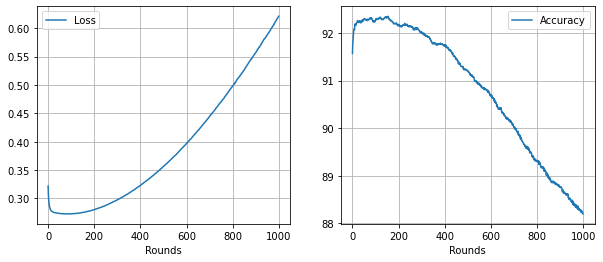

num_data: 1000
[Round: 0]  Round Loss: 0.3031216838955879  Round Acc: 91.80
[Round: 50]  Round Loss: 0.28894842967391016  Round Acc: 92.13
[Round: 100]  Round Loss: 0.29108305916190147  Round Acc: 92.04
[Round: 150]  Round Loss: 0.291868137717247  Round Acc: 91.96
[Round: 200]  Round Loss: 0.29273926131427286  Round Acc: 91.99
[Round: 250]  Round Loss: 0.29392727456986906  Round Acc: 92.00
[Round: 300]  Round Loss: 0.29519880563020706  Round Acc: 91.89
[Round: 350]  Round Loss: 0.2968624971807003  Round Acc: 91.80
[Round: 400]  Round Loss: 0.29852250419557097  Round Acc: 91.80
[Round: 450]  Round Loss: 0.3008709118515253  Round Acc: 91.73
[Round: 500]  Round Loss: 0.3030370996147394  Round Acc: 91.64
[Round: 550]  Round Loss: 0.3059350173175335  Round Acc: 91.61
[Round: 600]  Round Loss: 0.3087678376585245  Round Acc: 91.47
[Round: 650]  Round Loss: 0.3121346037834883  Round Acc: 91.39
[Round: 700]  Round Loss: 0.3156976979970932  Round Acc: 91.30
[Round: 750]  Round Loss: 0.3193325280

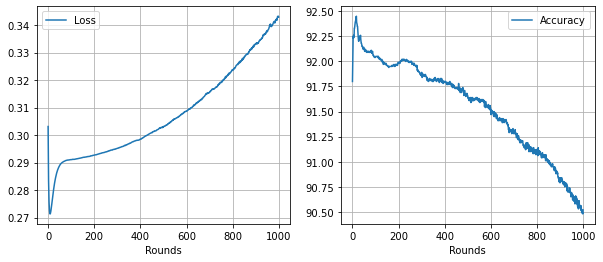

In [13]:
seed = 1228
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

# ====== Model Capacity ====== #
args.num_epochs = 5
args.num_rounds = 1000
args.num_clients = 3
args.lr = 0.0001

args.batch_size = 100
args.hidden_dim = 15
args.num_data = 100
args.reverse = True

name_var1 = 'reverse'
name_var2 = 'num_data'

list_var1 = [False, True]
list_var2 = [100, 500, 1000]


for var1 in list_var1:
    print(f"===== {name_var1}: {var1} =====")
    setattr(args, name_var1, var1)

    for var2 in list_var2:
        print(f"{name_var2}: {var2}")
        setattr(args, name_var2, var2)

        if args.reverse == True:
            args.enc_path = f"AE_model/client = {args.num_clients}/reverse/enc_num_data_{var2}.pth"
            args.dec_path = f"AE_model/client = {args.num_clients}/reverse/dec_num_data_{var2}.pth"
        else:  
            args.enc_path = f"AE_model/client = {args.num_clients}/enc_num_data_{var2}.pth"
            args.dec_path = f"AE_model/client = {args.num_clients}/dec_num_data_{var2}.pth"

        train_set_list = data_split(train_dataset, args)
        partition = {'train':train_set_list, 'test':test_dataset}

        round_losses, round_acces = experiment(partition, args)
        plot_loss(round_losses, round_acces)

##### **Averaged AutoEncoder**

===== reverse: False =====
num_data: 100
[Round: 0]  Round Loss: 0.49023212999105453  Round Acc: 91.60
[Round: 50]  Round Loss: 0.29402687162160873  Round Acc: 92.21
[Round: 100]  Round Loss: 0.29381417587399483  Round Acc: 92.22
[Round: 150]  Round Loss: 0.2923183818161488  Round Acc: 92.24
[Round: 200]  Round Loss: 0.29111662283539774  Round Acc: 92.28
[Round: 250]  Round Loss: 0.29011188462376597  Round Acc: 92.21
[Round: 300]  Round Loss: 0.2882235682755709  Round Acc: 92.18
[Round: 350]  Round Loss: 0.287139210999012  Round Acc: 92.26
[Round: 400]  Round Loss: 0.2856721866130829  Round Acc: 92.19
[Round: 450]  Round Loss: 0.2843997301161289  Round Acc: 92.20
[Round: 500]  Round Loss: 0.2829952384531498  Round Acc: 92.20
[Round: 550]  Round Loss: 0.2817879366874695  Round Acc: 92.21
[Round: 600]  Round Loss: 0.28064859196543696  Round Acc: 92.24
[Round: 650]  Round Loss: 0.27998273380100724  Round Acc: 92.23
[Round: 700]  Round Loss: 0.27931573629379275  Round Acc: 92.22
[Round: 75

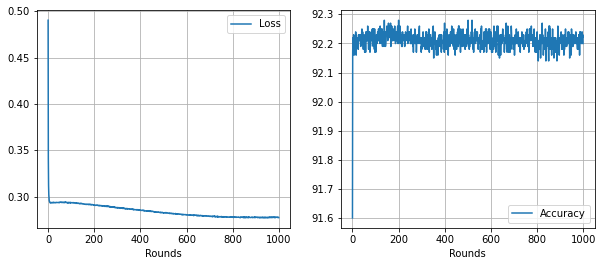

num_data: 500
[Round: 0]  Round Loss: 0.5045913517475128  Round Acc: 90.77
[Round: 50]  Round Loss: 0.28153501108288764  Round Acc: 92.12
[Round: 100]  Round Loss: 0.28136253662407396  Round Acc: 92.10
[Round: 150]  Round Loss: 0.280652869194746  Round Acc: 92.10
[Round: 200]  Round Loss: 0.27995193786919115  Round Acc: 92.11
[Round: 250]  Round Loss: 0.2798974698036909  Round Acc: 92.07
[Round: 300]  Round Loss: 0.279605196043849  Round Acc: 92.11
[Round: 350]  Round Loss: 0.27862853549420835  Round Acc: 92.15
[Round: 400]  Round Loss: 0.2787381473183632  Round Acc: 92.10
[Round: 450]  Round Loss: 0.2781090660393238  Round Acc: 92.12
[Round: 500]  Round Loss: 0.2778099276125431  Round Acc: 92.12
[Round: 550]  Round Loss: 0.2778759570419788  Round Acc: 92.10
[Round: 600]  Round Loss: 0.2776027814298868  Round Acc: 92.12
[Round: 650]  Round Loss: 0.27726296029984954  Round Acc: 92.14
[Round: 700]  Round Loss: 0.27692482866346835  Round Acc: 92.06
[Round: 750]  Round Loss: 0.276876526698

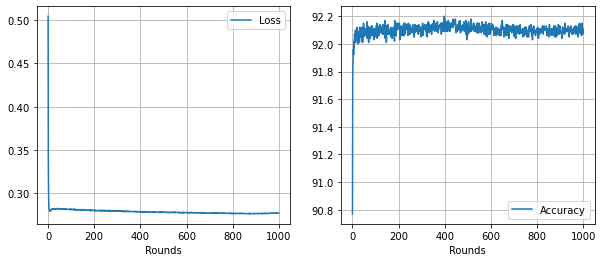

num_data: 1000
[Round: 0]  Round Loss: 0.4686605203151703  Round Acc: 91.50
[Round: 50]  Round Loss: 0.3067096262425184  Round Acc: 91.95
[Round: 100]  Round Loss: 0.3031294152885675  Round Acc: 91.96
[Round: 150]  Round Loss: 0.2998821776360273  Round Acc: 91.94
[Round: 200]  Round Loss: 0.2966984848678112  Round Acc: 91.94
[Round: 250]  Round Loss: 0.29344497628509997  Round Acc: 92.00
[Round: 300]  Round Loss: 0.29239016138017176  Round Acc: 92.01
[Round: 350]  Round Loss: 0.29128128223121164  Round Acc: 92.03
[Round: 400]  Round Loss: 0.2902717117965221  Round Acc: 92.04
[Round: 450]  Round Loss: 0.28949726492166517  Round Acc: 92.10
[Round: 500]  Round Loss: 0.2887356208264828  Round Acc: 92.13
[Round: 550]  Round Loss: 0.2874429428577423  Round Acc: 92.17
[Round: 600]  Round Loss: 0.28722948394715786  Round Acc: 92.10
[Round: 650]  Round Loss: 0.28623921997845175  Round Acc: 92.16
[Round: 700]  Round Loss: 0.2854453258961439  Round Acc: 92.14
[Round: 750]  Round Loss: 0.284243862

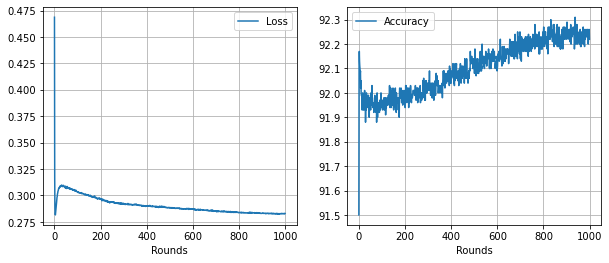

===== reverse: True =====
num_data: 100
[Round: 0]  Round Loss: 0.9039457458257675  Round Acc: 85.60
[Round: 50]  Round Loss: 0.28947544112801554  Round Acc: 91.78
[Round: 100]  Round Loss: 0.28641988068819046  Round Acc: 91.87
[Round: 150]  Round Loss: 0.2855833613872528  Round Acc: 91.93
[Round: 200]  Round Loss: 0.28404883489012717  Round Acc: 92.00
[Round: 250]  Round Loss: 0.2826740996539593  Round Acc: 92.02
[Round: 300]  Round Loss: 0.28215964294970036  Round Acc: 92.09
[Round: 350]  Round Loss: 0.2812616889923811  Round Acc: 92.07
[Round: 400]  Round Loss: 0.2806472150236368  Round Acc: 92.12
[Round: 450]  Round Loss: 0.2798833404481411  Round Acc: 92.11
[Round: 500]  Round Loss: 0.27965569399297235  Round Acc: 92.16
[Round: 550]  Round Loss: 0.2788561385124922  Round Acc: 92.18
[Round: 600]  Round Loss: 0.2789916191995144  Round Acc: 92.17
[Round: 650]  Round Loss: 0.2776929198205471  Round Acc: 92.20
[Round: 700]  Round Loss: 0.2785471597313881  Round Acc: 92.20
[Round: 750] 

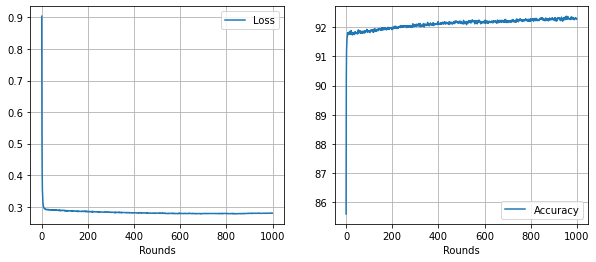

num_data: 500
[Round: 0]  Round Loss: 0.7975399440526962  Round Acc: 89.64
[Round: 50]  Round Loss: 6.248377610445022  Round Acc: 91.18
[Round: 100]  Round Loss: 195.34372741699218  Round Acc: 91.16
[Round: 150]  Round Loss: 5977.216418457031  Round Acc: 91.14
[Round: 200]  Round Loss: 183354.18099609375  Round Acc: 91.15
[Round: 250]  Round Loss: 5648505.5775  Round Acc: 91.17
[Round: 300]  Round Loss: 171525314.52  Round Acc: 91.15
[Round: 350]  Round Loss: 5261402021.76  Round Acc: 91.21
[Round: 400]  Round Loss: 161297080934.4  Round Acc: 91.18
[Round: 450]  Round Loss: 4949496413880.32  Round Acc: 91.21
[Round: 500]  Round Loss: 151718565908971.53  Round Acc: 91.19
[Round: 550]  Round Loss: 4625767788550554.0  Round Acc: 91.18
[Round: 600]  Round Loss: 1.4257839353333022e+17  Round Acc: 91.15
[Round: 650]  Round Loss: 4.388071760514672e+18  Round Acc: 91.19
[Round: 700]  Round Loss: 1.3429610625757648e+20  Round Acc: 91.09
[Round: 750]  Round Loss: 4.105479148807882e+21  Round Acc

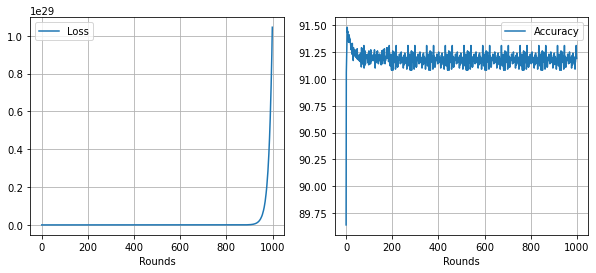

num_data: 1000
[Round: 0]  Round Loss: 0.5073695769906044  Round Acc: 91.21
[Round: 50]  Round Loss: 0.28200674802064896  Round Acc: 92.20
[Round: 100]  Round Loss: 0.2804685432463884  Round Acc: 92.22
[Round: 150]  Round Loss: 0.28017716102302076  Round Acc: 92.28
[Round: 200]  Round Loss: 0.28011228509247305  Round Acc: 92.24
[Round: 250]  Round Loss: 0.27993232414126396  Round Acc: 92.28
[Round: 300]  Round Loss: 0.2815151249617338  Round Acc: 92.23
[Round: 350]  Round Loss: 0.2827886686474085  Round Acc: 92.21
[Round: 400]  Round Loss: 0.2836882972717285  Round Acc: 92.24
[Round: 450]  Round Loss: 0.2858701522648335  Round Acc: 92.30
[Round: 500]  Round Loss: 0.287135783880949  Round Acc: 92.26
[Round: 550]  Round Loss: 0.2842633591592312  Round Acc: 92.31
[Round: 600]  Round Loss: 0.28241463251411913  Round Acc: 92.25
[Round: 650]  Round Loss: 0.28008088931441305  Round Acc: 92.30
[Round: 700]  Round Loss: 0.27881777241826056  Round Acc: 92.28
[Round: 750]  Round Loss: 0.278178482

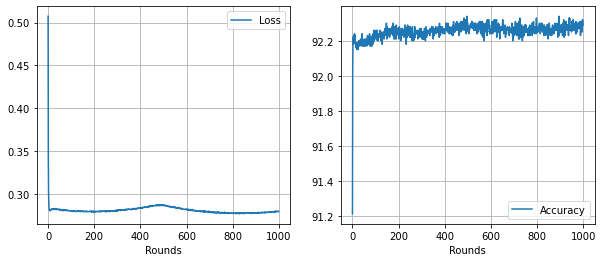

In [23]:
seed = 1228
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

# ====== Model Capacity ====== #
args.num_epochs = 5
args.num_rounds = 1000
args.num_clients = 3
args.lr = 0.0001

args.batch_size = 100
args.hidden_dim = 15
args.num_data = 100
args.reverse = True

name_var1 = 'reverse'
name_var2 = 'num_data'

list_var1 = [False, True]
list_var2 = [100, 500, 1000]


for var1 in list_var1:
    print(f"===== {name_var1}: {var1} =====")
    setattr(args, name_var1, var1)

    for var2 in list_var2:
        print(f"{name_var2}: {var2}")
        setattr(args, name_var2, var2)

        if args.reverse == True:
            args.enc_path = f"w_avg_AE_model/client = {args.num_clients}/reverse/enc_num_data_{var2}.pth"
            args.dec_path = f"w_avg_AE_model/client = {args.num_clients}/reverse/dec_num_data_{var2}.pth"
        else:  
            args.enc_path = f"w_avg_AE_model/client = {args.num_clients}/enc_num_data_{var2}.pth"
            args.dec_path = f"w_avg_AE_model/client = {args.num_clients}/dec_num_data_{var2}.pth"

        train_set_list = data_split(train_dataset, args)
        partition = {'train':train_set_list, 'test':test_dataset}

        round_losses, round_acces = experiment(partition, args)
        plot_loss(round_losses, round_acces)

##### **More Data(round=500)**

===== reverse: False =====
num_data: 150
[Round: 0]  Round Loss: 0.345942947268486  Round Acc: 91.44
[Round: 50]  Round Loss: 0.32452972859144213  Round Acc: 92.57
[Round: 100]  Round Loss: 0.3371959389746189  Round Acc: 92.52
[Round: 150]  Round Loss: 0.34982001677155494  Round Acc: 92.52
[Round: 200]  Round Loss: 0.3621603521704674  Round Acc: 92.51
[Round: 250]  Round Loss: 0.3782093632221222  Round Acc: 92.53
[Round: 300]  Round Loss: 0.39793720841407776  Round Acc: 92.47
[Round: 350]  Round Loss: 0.42049015998840333  Round Acc: 92.37
[Round: 400]  Round Loss: 0.4360469049215317  Round Acc: 92.32
[Round: 450]  Round Loss: 0.443451871573925  Round Acc: 92.23
[Round: 499]  Round Loss: 0.45110651433467863  Round Acc: 92.13


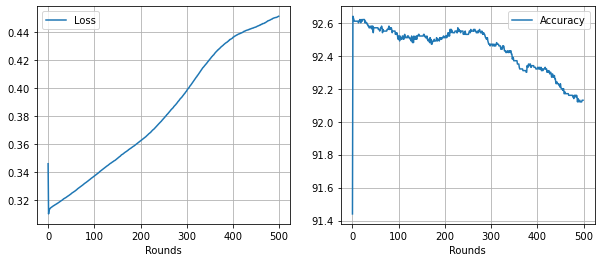

num_data: 300
[Round: 0]  Round Loss: 0.28723621167242525  Round Acc: 92.10
[Round: 50]  Round Loss: 0.2897754554450512  Round Acc: 92.49
[Round: 100]  Round Loss: 0.2983594094216824  Round Acc: 92.52
[Round: 150]  Round Loss: 0.308953014165163  Round Acc: 92.47
[Round: 200]  Round Loss: 0.3228139440715313  Round Acc: 92.42
[Round: 250]  Round Loss: 0.3396005102992058  Round Acc: 92.40
[Round: 300]  Round Loss: 0.35937567085027694  Round Acc: 92.29
[Round: 350]  Round Loss: 0.38171626716852186  Round Acc: 92.32
[Round: 400]  Round Loss: 0.40334006875753403  Round Acc: 92.23
[Round: 450]  Round Loss: 0.4167125657200813  Round Acc: 92.17
[Round: 499]  Round Loss: 0.4262212026119232  Round Acc: 92.15


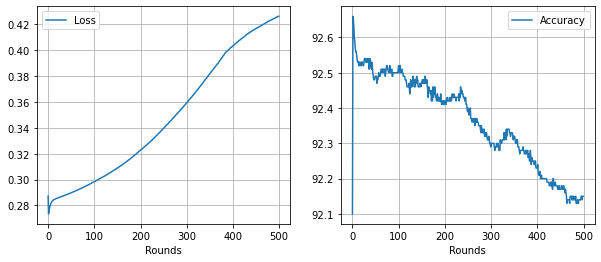

num_data: 900
[Round: 0]  Round Loss: 0.28389674335718157  Round Acc: 92.16
[Round: 50]  Round Loss: 0.2901109339296818  Round Acc: 91.86
[Round: 100]  Round Loss: 0.29140068143606185  Round Acc: 91.85
[Round: 150]  Round Loss: 0.293251877874136  Round Acc: 91.86
[Round: 200]  Round Loss: 0.2959107513725758  Round Acc: 91.86
[Round: 250]  Round Loss: 0.2985943569242954  Round Acc: 91.86
[Round: 300]  Round Loss: 0.3014875030517578  Round Acc: 91.88
[Round: 350]  Round Loss: 0.30444699421525  Round Acc: 91.86
[Round: 400]  Round Loss: 0.304076536744833  Round Acc: 92.25
[Round: 450]  Round Loss: 0.3048162943124771  Round Acc: 92.48
[Round: 499]  Round Loss: 0.3065894335508347  Round Acc: 92.61


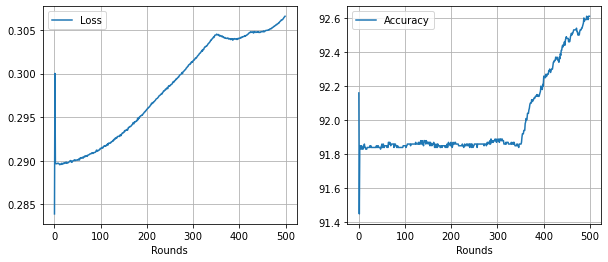

num_data: 1500
[Round: 0]  Round Loss: 0.2996937968581915  Round Acc: 91.85
[Round: 50]  Round Loss: 0.29090149827301504  Round Acc: 92.66
[Round: 100]  Round Loss: 0.28941351488232614  Round Acc: 92.65
[Round: 150]  Round Loss: 0.28705154933035376  Round Acc: 92.66
[Round: 200]  Round Loss: 0.28456864461302755  Round Acc: 92.65
[Round: 250]  Round Loss: 0.2822238180041313  Round Acc: 92.72
[Round: 300]  Round Loss: 0.2790754529833794  Round Acc: 92.77
[Round: 350]  Round Loss: 0.2762790261209011  Round Acc: 92.81
[Round: 400]  Round Loss: 0.2744446446746588  Round Acc: 92.85
[Round: 450]  Round Loss: 0.27352868802845476  Round Acc: 92.76
[Round: 499]  Round Loss: 0.2735930586606264  Round Acc: 92.79


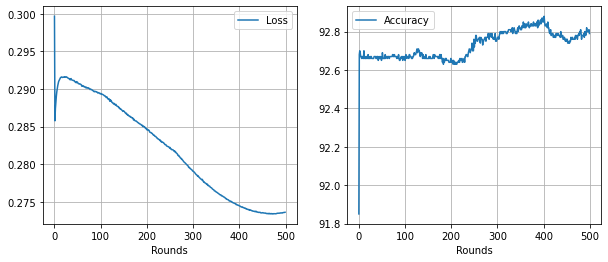

===== reverse: True =====
num_data: 150
[Round: 0]  Round Loss: 0.2836617368459702  Round Acc: 92.30
[Round: 50]  Round Loss: 0.3366043891012669  Round Acc: 92.28
[Round: 100]  Round Loss: 0.3400852175056934  Round Acc: 92.25
[Round: 150]  Round Loss: 0.34324317663908005  Round Acc: 92.28
[Round: 200]  Round Loss: 0.347626581043005  Round Acc: 92.27
[Round: 250]  Round Loss: 0.3542399489879608  Round Acc: 92.26
[Round: 300]  Round Loss: 0.36244615823030474  Round Acc: 92.23
[Round: 350]  Round Loss: 0.37213038265705106  Round Acc: 92.25
[Round: 400]  Round Loss: 0.38277819961309434  Round Acc: 92.22
[Round: 450]  Round Loss: 0.3935166993737221  Round Acc: 92.18
[Round: 499]  Round Loss: 0.4040548461675644  Round Acc: 92.18


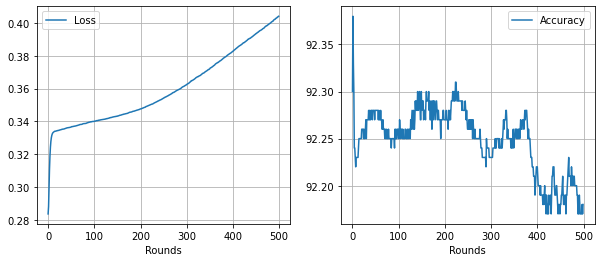

num_data: 300
[Round: 0]  Round Loss: 0.2994777811318636  Round Acc: 91.57
[Round: 50]  Round Loss: 0.2976526927947998  Round Acc: 92.63
[Round: 100]  Round Loss: 0.3114394234120846  Round Acc: 92.55
[Round: 150]  Round Loss: 0.32989005401730537  Round Acc: 92.52
[Round: 200]  Round Loss: 0.3534886549413204  Round Acc: 92.38
[Round: 250]  Round Loss: 0.3769142666459084  Round Acc: 92.38
[Round: 300]  Round Loss: 0.4065338197350502  Round Acc: 92.35
[Round: 350]  Round Loss: 0.4388226255774498  Round Acc: 92.31
[Round: 400]  Round Loss: 0.453702929019928  Round Acc: 92.27
[Round: 450]  Round Loss: 0.4649742031097412  Round Acc: 92.21
[Round: 499]  Round Loss: 0.4697654789686203  Round Acc: 92.17


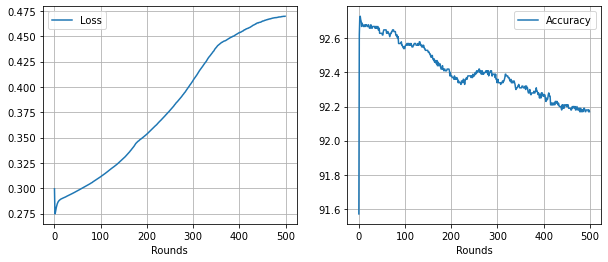

num_data: 900
[Round: 0]  Round Loss: 0.33394000232219695  Round Acc: 90.34
[Round: 50]  Round Loss: 0.4078210711479187  Round Acc: 91.72
[Round: 100]  Round Loss: 0.4372063484787941  Round Acc: 91.62
[Round: 150]  Round Loss: 0.4489077106118202  Round Acc: 91.56
[Round: 200]  Round Loss: 0.4375440201163292  Round Acc: 91.72
[Round: 250]  Round Loss: 0.38132890582084655  Round Acc: 92.19
[Round: 300]  Round Loss: 0.3456436125934124  Round Acc: 92.33
[Round: 350]  Round Loss: 0.3205197833478451  Round Acc: 92.62
[Round: 400]  Round Loss: 0.3034692612290382  Round Acc: 92.65
[Round: 450]  Round Loss: 0.30222744852304456  Round Acc: 92.67
[Round: 499]  Round Loss: 0.3016112443804741  Round Acc: 92.69


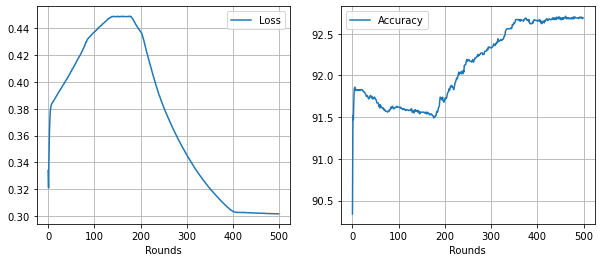

num_data: 1500
[Round: 0]  Round Loss: 0.33309259921312334  Round Acc: 90.86
[Round: 50]  Round Loss: 0.2814109755307436  Round Acc: 92.87
[Round: 100]  Round Loss: 0.2833001178503036  Round Acc: 92.87
[Round: 150]  Round Loss: 0.285236112177372  Round Acc: 92.87
[Round: 200]  Round Loss: 0.28733243271708486  Round Acc: 92.88
[Round: 250]  Round Loss: 0.2895638990402222  Round Acc: 92.86
[Round: 300]  Round Loss: 0.2920739071071148  Round Acc: 92.90
[Round: 350]  Round Loss: 0.2947586700320244  Round Acc: 92.89
[Round: 400]  Round Loss: 0.29772692173719406  Round Acc: 92.91
[Round: 450]  Round Loss: 0.30123417124152185  Round Acc: 92.83
[Round: 499]  Round Loss: 0.3051159179210663  Round Acc: 92.79


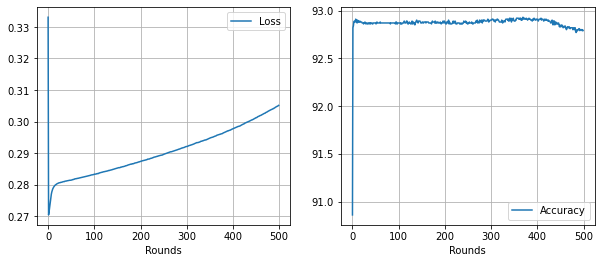

In [13]:
seed = 201912155
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

# ====== Model Capacity ====== #
args.num_epochs = 5
args.num_rounds = 500
args.num_clients = 3
args.lr = 0.0001

args.batch_size = 100
args.hidden_dim = 15
args.num_data = 100
args.reverse = True

name_var1 = 'reverse'
name_var2 = 'num_data'

list_var1 = [False, True]
list_var2 = [50, 100, 300, 500]


for var1 in list_var1:
    print(f"===== {name_var1}: {var1} =====")
    setattr(args, name_var1, var1)

    for var2 in list_var2:
        print(f"{name_var2}: {var2*5}") #3으로 잘못입력
        setattr(args, name_var2, var2)

        if args.reverse == True:
            args.enc_path = f"FL(mining_data)/w_avg_AE_model/client = {args.num_clients}/reverse/enc_num_data_{var2}.pth"
            args.dec_path = f"FL(mining_data)/w_avg_AE_model/client = {args.num_clients}/reverse/dec_num_data_{var2}.pth"
        else:  
            args.enc_path = f"FL(mining_data)/w_avg_AE_model/client = {args.num_clients}/enc_num_data_{var2}.pth"
            args.dec_path = f"FL(mining_data)/w_avg_AE_model/client = {args.num_clients}/dec_num_data_{var2}.pth"

        train_set_list = data_split(train_dataset, args)
        partition = {'train':train_set_list, 'test':test_dataset}

        round_losses, round_acces = experiment(partition, args)
        plot_loss(round_losses, round_acces)

##### **Best_Seed**

[reverse: False]
[Round: 0]  Round Loss: 0.3014183706045151  Round Acc: 91.44
[Round: 50]  Round Loss: 0.2902246015518904  Round Acc: 91.86
[Round: 100]  Round Loss: 0.29148527190089224  Round Acc: 91.85
[Round: 150]  Round Loss: 0.29333789795637133  Round Acc: 91.86
[Round: 200]  Round Loss: 0.29581241130828856  Round Acc: 91.86
[Round: 250]  Round Loss: 0.2986794398725033  Round Acc: 91.85
[Round: 300]  Round Loss: 0.3014793936908245  Round Acc: 91.88
[Round: 350]  Round Loss: 0.30457679867744447  Round Acc: 91.85
[Round: 400]  Round Loss: 0.3040598827600479  Round Acc: 92.25
[Round: 450]  Round Loss: 0.3048431584239006  Round Acc: 92.48
[Round: 500]  Round Loss: 0.30656314432621  Round Acc: 92.60
[Round: 550]  Round Loss: 0.30775991573929784  Round Acc: 92.68
[Round: 600]  Round Loss: 0.3061089204251766  Round Acc: 92.69
[Round: 650]  Round Loss: 0.30384021028876307  Round Acc: 92.72
[Round: 700]  Round Loss: 0.3010025818645954  Round Acc: 92.75
[Round: 750]  Round Loss: 0.297992041

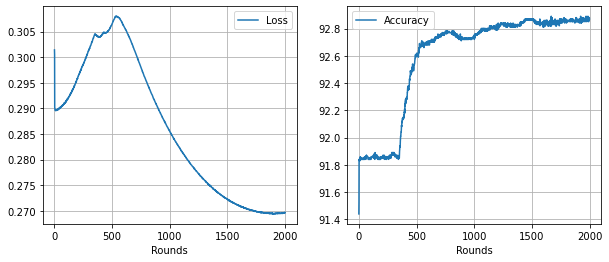

[reverse: True]
[Round: 0]  Round Loss: 0.32783980563282966  Round Acc: 90.57
[Round: 50]  Round Loss: 0.4078509438037872  Round Acc: 91.71
[Round: 100]  Round Loss: 0.4369540184736252  Round Acc: 91.62
[Round: 150]  Round Loss: 0.4486519315838814  Round Acc: 91.56
[Round: 200]  Round Loss: 0.43723374426364897  Round Acc: 91.72
[Round: 250]  Round Loss: 0.3811428180336952  Round Acc: 92.20
[Round: 300]  Round Loss: 0.34570981115102767  Round Acc: 92.33
[Round: 350]  Round Loss: 0.3206363591551781  Round Acc: 92.61
[Round: 400]  Round Loss: 0.30311028346419333  Round Acc: 92.67
[Round: 450]  Round Loss: 0.3020355945825577  Round Acc: 92.69
[Round: 500]  Round Loss: 0.30143130987882616  Round Acc: 92.71
[Round: 550]  Round Loss: 0.30072557225823404  Round Acc: 92.71
[Round: 600]  Round Loss: 0.2999170736968517  Round Acc: 92.71
[Round: 650]  Round Loss: 0.29915419697761536  Round Acc: 92.74
[Round: 700]  Round Loss: 0.2982741978764534  Round Acc: 92.73
[Round: 750]  Round Loss: 0.2974253

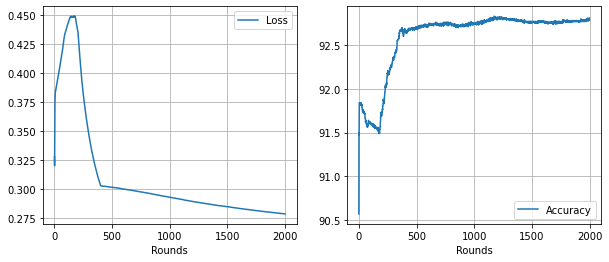

In [14]:
seed = 201912155
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

# ====== Model Capacity ====== #
args.num_epochs = 5
args.num_rounds = 2000
args.num_clients = 3
args.lr = 0.0001

args.batch_size = 100
args.hidden_dim = 15
args.num_data = 300
args.reverse = False


name_var = 'reverse'
list_var = [False, True]

for var in list_var:
    print(f"[{name_var}: {var}]")
    setattr(args, name_var, var)

    if args.reverse == True:
        args.enc_path = f"FL(mining_data)/w_avg_AE_model/client = {args.num_clients}/reverse/enc_num_data_{args.num_data}.pth"
        args.dec_path = f"FL(mining_data)/w_avg_AE_model/client = {args.num_clients}/reverse/dec_num_data_{args.num_data}.pth"
    else:  
        args.enc_path = f"FL(mining_data)/w_avg_AE_model/client = {args.num_clients}/enc_num_data_{args.num_data}.pth"
        args.dec_path = f"FL(mining_data)/w_avg_AE_model/client = {args.num_clients}/dec_num_data_{args.num_data}.pth"
    train_set_list = data_split(train_dataset, args)
    partition = {'train':train_set_list, 'test':test_dataset}
    round_losses, round_acces = experiment(partition, args)
    plot_loss(round_losses, round_acces)